In [1]:
# %% Import Libraries
#This is a test
import os
import pickle
import scipy.io
import numpy as np
import pandas as pd
import torch as tc
import matplotlib.pyplot as plt

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

import matplotlib.patches as mpatches
from tqdm import tqdm
from bptt.models import Model
import model_anafunctions as func

plt.rcParams['font.size'] = 20

C:\Users\cestarellas\anaconda3\envs\PLAna\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#%% FUNCTIONS
def Hyper_mod(mpath,data_path):
    file=open(os.path.join(mpath,'hypers.pkl').replace("\\","/"),'rb')
    hyper=pickle.load(file)
    file.close()
    hyper['data_path']=os.path.join(data_path,'Training_data.npy').replace('\\','/')
    hyper['inputs_path']=os.path.join(data_path,'Training_inputs.npy').replace('\\','/')
    hyper['device_id'] = 0
    full_name = open(os.path.join(mpath,'hypers.pkl').replace("\\","/"),"wb")                      # Name for training data
    pickle.dump(hyper,full_name)            # Save train data
    #close save instance 
    full_name.close()

In [3]:
#%% Data Organization
# General Directories
path_models = 'D:\\_work_cestarellas\\Analysis\\Pack_Daniel_project\\Preprocess_model\\' # For models and Training and Test data
path_behaviours = 'D:\\_work_cestarellas\\Analysis\\PLRNN\\Session_Selected\\OFC'        # For behavioural sessions

#Model
mod_sessions = os.listdir(path_models)
extra_models = 'results\\DataTrainingH768_lm1_1e-05_lm2_128_lm3_00_seql_400\\001'
#Neuronal Activity
extra_activity = 'neuralactivity\\datasets\\'
#Behaviour
rec_sessions = os.listdir(path_behaviours)

#################### WARNING
# Be careful!!! Check if the order of mod_sessions and rec_sessions is the same
#################### WARNING

In [4]:
mod_sessions

['bptt_CE17', 'bptt_DM01_5', 'bptt_DM01_7', 'bptt_JG15_24', 'bptt_JG15_25']

In [5]:
rec_sessions

['CE17_L6',
 'DM01_5_220522',
 'DM01_7_220524',
 'JG15_190724_clustered',
 'JG15_190725_clustered']

In [6]:
# FUNCTION

def Preproces_data(data_path,mpath,num_epoch):
    # Loading Train and Test data    
    train_n,train_i = func.load_data(data_path,'Training')
    test_n,test_i = func.load_data(data_path,'Test')

    # Loading Model
    num_epochs = num_epoch
    m = Model()
    m.init_from_model_path(mpath, epoch=num_epochs)
    m.eval()

    # Generation Training Data
    ModelS=[]
    for w_index in tqdm(range(len(train_n))):
        data_trial=tc.from_numpy(train_n[w_index]).float()          # tensor of neuronal data for initial trial data
        input_trial = tc.from_numpy(train_i[w_index]).float()
        length_sim = input_trial.shape[0]
        X, _ = m.generate_free_trajectory(data_trial,input_trial,length_sim,w_index)
        ModelS.append(X[:,:])

    # Concatenating signals
    Nseries,_=func.concatenate_list(train_n,0)          # recorded activity
    Iseries,_=func.concatenate_list(train_i,0)          # external input
    Mseries,_=func.concatenate_list(ModelS,0)           # simulated activity
    
    # Identification of training trials in full behaviour (Tr_behaviour)
    # Open the file in binary mode
    Meta_file_path = os.path.join(data_path,'Metadata.pkl').replace('\\','/')
    with open(Meta_file_path, "rb") as f:
        # Load the pickled data
        Meta_info = pickle.load(f)

    Test_trials = Meta_info["TestTrials"]; Training_trials = Meta_info["TrainingTrials"]    

    itrain = 0
    itest = 0
    Trials_inmodel = []
    for i in range(len(Meta_info["TestTrials"])+len(Meta_info["TrainingTrials"])):
        if i in Meta_info["TrainingTrials"]:
            Trials_inmodel.append(np.sum(np.diff(train_i[itrain][:,0])==1))
            itrain += 1
        elif i in Meta_info["TestTrials"]:
            Trials_inmodel.append(np.sum(np.diff(test_i[itest][:,0])==1))
            itest +=1

    # Cumulative sum of the behavioural trials in concatenated trials        
    CUM_trials = [np.sum(Trials_inmodel[:i]) for i in range(len(Trials_inmodel)+1)]

    Ini_beh = [0]+[CUM_trials[i+1] for i in Test_trials]
    End_beh = [CUM_trials[i] for i in Test_trials]+[CUM_trials[-1]]

    Tr_behaviour = []
    for k in range(len(Ini_beh)):
        Tr_behaviour= Tr_behaviour+[i for i in range(Ini_beh[k],End_beh[k])]

    return Nseries,Mseries,Iseries,Tr_behaviour

In [7]:
# FUNCTION
def Behaviour_variables(behaviour_path,Tr_behaviour):
    
    # Selection of the file
    os.chdir(behaviour_path)
    list_files = os.listdir(behaviour_path)
    for i in list_files:
        if i.find('Behaviour')>0:
            Behaviour_name = i

    # Load data
    # Open the Behaviour file
    Bdata = scipy.io.loadmat(Behaviour_name)
    BehData = Bdata[list(Bdata.keys())[-1]]

    # Next Decision (Gamble [1] - Safe [0])
    ND_se = (BehData[:,12]==1)*1+(BehData[:,12]==0)*0
    ND = ND_se[Tr_behaviour]
    
    # Reward (Gamble [2], Safe [1], Nothing [0])
    RW_se = (BehData[:,12]==1)*(BehData[:,13])*2+(BehData[:,13])*(BehData[:,12]==0)*1
    RW = RW_se[Tr_behaviour]

    # Blocks (High [2], Medium [1], Low [0]): The value depends on the organization of the variable "blocks"
    blocks=np.unique(BehData[:,5])
    if len(blocks)==3:
        B_se=(BehData[:,5]==blocks[0])*0+(BehData[:,5]==blocks[1])*1+(BehData[:,5]==blocks[2])*2
    elif len(blocks)==2:
        B_se=(BehData[:,5]==blocks[0])*0+(BehData[:,5]==blocks[1])*1
    elif len(blocks)<2:
        print("There is no different blocks to classify the data")
    else:
        print("This is not the original task")
    BI = B_se[Tr_behaviour]
    
    return ND,RW,BI

In [8]:
# FUNCTION
def Classification_Choice(Nseries,Mseries,Iseries,ND):

    # Firing Rate Neurons

    # Temporal sectors: Period of time selected to compute the mean firing rate
    Time_ini = np.where(np.diff(Iseries[:,0])==1)[0]-49                        # Initial point:beginning wheel stop
    Time_end = np.where(np.diff(Iseries[:,0])==-1)[0]                          # Final point: ending execution time. Just before reward
    
    # Data Set Mean Activity Zscore Neurons
    num_trials = len(Time_end)
    num_neurons = Nseries.shape[1]
    X_data = np.zeros((num_trials,num_neurons))
    X_model = np.zeros((num_trials,num_neurons))
    for it in range(num_trials):
        X_data[it,:]=np.mean(Nseries[Time_ini[it]:Time_end[it],:],0)
        X_model[it,:]=np.mean(Mseries[Time_ini[it]:Time_end[it],:],0)


    #%% Next Choice
    score_data=[]
    score_model=[]
    score_modelSh=[]
    score_dataSh=[]

    clf = LinearDiscriminantAnalysis()
    for i in range(1000):
        list_trials=np.linspace(0,X_data.shape[0]-1,X_data.shape[0]).astype(int)
        np.random.shuffle(list_trials)
        # Classifying data
        X=X_data[list_trials,:]
        y=ND[list_trials]
        random_state=0
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=0
            )
        clf.fit(X_train,y_train)
        score_data.append(clf.score(X_test,y_test))

        # Classifying model
        Xm=X_model[list_trials,:]
        random_state=0
        X_trainM, X_testM, y_trainM, y_testM = train_test_split(
            Xm, y, test_size=0.2, stratify=y, random_state=0
            )
        random_state=0
        clf.fit(X_trainM,y_trainM)
        score_model.append(clf.score(X_testM,y_testM))

        # Classifying data Shuffle
        list_trials=np.linspace(0,X_data.shape[0]-1,X_data.shape[0]).astype(int)
        y=ND[list_trials]
        random_state=0
        X_trainS, X_testS, y_trainS, y_testS = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=0
            )

        clf.fit(X_trainS,y_trainS)
        score_dataSh.append(clf.score(X_testS,y_testS))
        # Classifying model Shuffle
        X_trainMS, X_testMS, y_trainMS, y_testMS = train_test_split(
            Xm, y, test_size=0.2, stratify=y, random_state=0
            )
        clf.fit(X_trainMS,y_trainMS)
        score_modelSh.append(clf.score(X_testMS,y_testMS))
    return score_data, score_model

In [9]:
# FUNCTION

def Classification_Reward(Nseries,Mseries,Iseries,RW):
    # Classification of the Type of Reward in the trials with information during reward and ITI period
    # The previous information is the mean firing rate of each neuron from Reward until the initial point of the following trial

    # Firing Rate Neurons
    # Temporal sectors: Period of time selected to compute the mean firing rate
    RewTime_ini = np.where(np.diff(Iseries[:,0])==-1)[0]                       # Initial point: beginning reward
    RT_end = np.where(np.diff(Iseries[:,0])==1)[0]-49
    RewTime_end = np.append(RT_end[1:],Iseries.shape[0])                       # Final point: ending Inter-Trial Interval (beggining following trial)

    # Data Set Mean Activity Zscore Neurons
    num_trials = len(RewTime_end)
    num_neurons = Nseries.shape[1]
    X_data = np.zeros((num_trials,num_neurons))
    X_model = np.zeros((num_trials,num_neurons))
    for it in range(num_trials):
        X_data[it,:]=np.mean(Nseries[RewTime_ini[it]:RewTime_end[it],:],0)
        X_model[it,:]=np.mean(Mseries[RewTime_ini[it]:RewTime_end[it],:],0)
        

    #%% Reward Identification
    score_data=[]
    score_model=[]
    score_modelSh=[]
    score_dataSh=[]

    clf = LinearDiscriminantAnalysis()
    for i in range(1000):
        list_trials=np.linspace(0,X_data.shape[0]-1,X_data.shape[0]).astype(int)
        np.random.shuffle(list_trials)
        # Classifying data
        X=X_data[list_trials,:]
        y=RW[list_trials]
        random_state=0
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=0
            )
        clf.fit(X_train,y_train)
        score_data.append(clf.score(X_test,y_test))

        # Classifying model
        Xm=X_model[list_trials,:]
        random_state=0
        X_trainM, X_testM, y_trainM, y_testM = train_test_split(
            Xm, y, test_size=0.2, stratify=y, random_state=0
            )
        random_state=0
        clf.fit(X_trainM,y_trainM)
        score_model.append(clf.score(X_testM,y_testM))

        # Classifying data Shuffle
        list_trials=np.linspace(0,X_data.shape[0]-1,X_data.shape[0]).astype(int)
        y=RW[list_trials]
        random_state=0
        X_trainS, X_testS, y_trainS, y_testS = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=0
            )

        clf.fit(X_trainS,y_trainS)
        score_dataSh.append(clf.score(X_testS,y_testS))
        # Classifying model Shuffle
        X_trainMS, X_testMS, y_trainMS, y_testMS = train_test_split(
            Xm, y, test_size=0.2, stratify=y, random_state=0
            )
        clf.fit(X_trainMS,y_trainMS)
        score_modelSh.append(clf.score(X_testMS,y_testMS))
    return score_data, score_model

In [10]:
# FUNCTION
def Classification_Block(Nseries,Mseries,Iseries,BI):
    # Classification of the Type of Reward in the trials with information during reward and ITI period
    # The previous information is the mean firing rate of each neuron from Reward until the initial point of the following trial

    # Firing Rate Neurons

    # Temporal sectors: Period of time selected to compute the mean firing rate
    TrialTime_ini = np.where(np.diff(Iseries[:,0])==1)[0]-49                 # Initial point: Beginning trial
    TrialTime_end = np.append(TrialTime_ini[1:],Iseries.shape[0])                   # Final point: Ending trial

    # Data Set Mean Activity Zscore Neurons
    num_trials = len(TrialTime_end)
    num_neurons = Nseries.shape[1]
    X_data = np.zeros((num_trials,num_neurons))
    X_model = np.zeros((num_trials,num_neurons))
    for it in range(num_trials):
        X_data[it,:]=np.mean(Nseries[TrialTime_ini[it]:TrialTime_end[it],:],0)
        X_model[it,:]=np.mean(Mseries[TrialTime_ini[it]:TrialTime_end[it],:],0)


    #%% Reward Identification
    score_data=[]
    score_model=[]
    score_modelSh=[]
    score_dataSh=[]

    clf = LinearDiscriminantAnalysis()
    for i in range(1000):
        list_trials=np.linspace(0,X_data.shape[0]-1,X_data.shape[0]).astype(int)
        np.random.shuffle(list_trials)
        # Classifying data
        X=X_data[list_trials,:]
        y=BI[list_trials]
        random_state=0
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=0
            )
        clf.fit(X_train,y_train)
        score_data.append(clf.score(X_test,y_test))

        # Classifying model
        Xm=X_model[list_trials,:]
        random_state=0
        X_trainM, X_testM, y_trainM, y_testM = train_test_split(
            Xm, y, test_size=0.2, stratify=y, random_state=0
            )
        random_state=0
        clf.fit(X_trainM,y_trainM)
        score_model.append(clf.score(X_testM,y_testM))

        # Classifying data Shuffle
        list_trials=np.linspace(0,X_data.shape[0]-1,X_data.shape[0]).astype(int)
        y=BI[list_trials]
        random_state=0
        X_trainS, X_testS, y_trainS, y_testS = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=0
            )

        clf.fit(X_trainS,y_trainS)
        score_dataSh.append(clf.score(X_testS,y_testS))
        # Classifying model Shuffle
        X_trainMS, X_testMS, y_trainMS, y_testMS = train_test_split(
            Xm, y, test_size=0.2, stratify=y, random_state=0
            )
        clf.fit(X_trainMS,y_trainMS)
        score_modelSh.append(clf.score(X_testMS,y_testMS))
    return score_data, score_model


In [11]:
num_sessions = len(mod_sessions)
last_epoch = 150000
Choice_rec = [] ; Choice_gen =[]
Reward_rec = [] ; Reward_gen =[]
Block_rec = [] ; Block_gen =[]


for isess in range(num_sessions):
    Neural_path = os.path.join(path_models,mod_sessions[isess],extra_activity)
    Model_path = os.path.join(path_models,mod_sessions[isess],extra_models).replace('\\','/')
    Behavioural_path = os.path.join(path_behaviours,rec_sessions[isess]).replace('\\','/')
    Hyper_mod(Model_path,Neural_path)
    Rec_activity,Gen_activity,EI_signal,Trials_beh = Preproces_data(Neural_path,Model_path,last_epoch)
    Choice_id,Reward_id,Blocks_id = Behaviour_variables(Behavioural_path,Trials_beh)
    # Classification Choice
    Ac_rec_choice,Ac_gen_choice = Classification_Choice(Rec_activity,Gen_activity,EI_signal,Choice_id)
    Choice_rec=Choice_rec+[(np.array(Ac_rec_choice).mean())]#Ac_rec_choice#
    Choice_gen=Choice_gen+[(np.array(Ac_gen_choice).mean())]#Ac_gen_choice#
    # Classification Reward
    Ac_rec_reward,Ac_gen_reward = Classification_Reward(Rec_activity,Gen_activity,EI_signal,Reward_id)
    Reward_rec=Reward_rec+[(np.array(Ac_rec_reward).mean())]#Ac_rec_reward#
    Reward_gen=Reward_gen+[(np.array(Ac_gen_reward).mean())]#Ac_gen_reward#
    # Classification Block
    Ac_rec_block,Ac_gen_block = Classification_Block(Rec_activity,Gen_activity,EI_signal,Blocks_id)
    Block_rec=Block_rec+[(np.array(Ac_rec_block).mean())]#Ac_rec_block#
    Block_gen=Block_gen+[(np.array(Ac_gen_block).mean())]#Ac_gen_block#
        

Chosen model is clipped shPLRNN, the bases Parameter has no effect here!


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:05<00:00,  9.35it/s]


Chosen model is clipped shPLRNN, the bases Parameter has no effect here!


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:05<00:00, 10.06it/s]


Chosen model is clipped shPLRNN, the bases Parameter has no effect here!


100%|██████████████████████████████████████████████████████████████████████████████████| 88/88 [00:09<00:00,  9.36it/s]


Chosen model is clipped shPLRNN, the bases Parameter has no effect here!


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:05<00:00,  8.78it/s]


Chosen model is clipped shPLRNN, the bases Parameter has no effect here!


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:03<00:00,  9.51it/s]


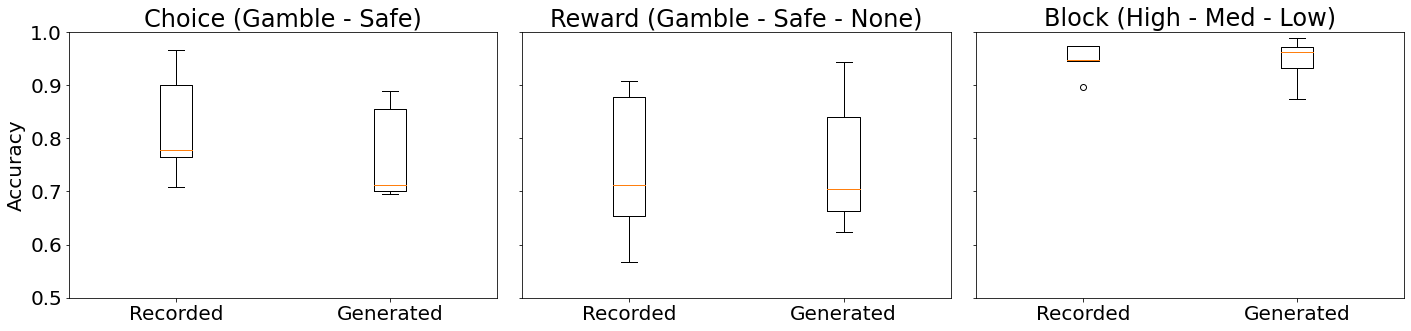

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
Models = ['Recorded','Generated']
axs[0].boxplot([Choice_rec,Choice_gen],labels=Models)
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Choice (Gamble - Safe)')
axs[0].set_ylim([0.5,1])
axs[1].boxplot([Reward_rec,Reward_gen],labels=Models)
axs[1].set_title('Reward (Gamble - Safe - None)')
axs[2].boxplot([Block_rec,Block_gen],labels=Models)
axs[2].set_title('Block (High - Med - Low)')
plt.tight_layout()
# Save Figure
fig.savefig("D:/_work_cestarellas/Analysis/Pack_Daniel_project/Figures/3_Figure/Accuracy_predictions.png")
plt.show()

In [14]:
from scipy import stats
# Perform the t-test
t_statistic, p_value = stats.ttest_ind(Choice_rec, Choice_gen)
# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)
# Perform the t-test
t_statistic, p_value = stats.ttest_ind(Reward_rec, Reward_gen)
# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)
# Perform the t-test
t_statistic, p_value = stats.ttest_ind(Block_rec, Block_gen)
# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: 0.838147618968028
P-value: 0.42627871491876834
T-statistic: -0.12503207364603305
P-value: 0.9035829728031126
T-statistic: 0.0877547413015114
P-value: 0.9322284972402427
